### Print Start time

In [ ]:
# import datetime
import datetime 
import pytz  
# current date and time
Start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
print("DateTime:", Start_time)

DateTime: 2020-06-23 16:37:47.926913+05:30


### Import Libraries

In [ ]:
import numpy as np

## Input parameters
Here there are two types of input parameter involve which are initial parameter i.e. N,n,s and controlling parameter i.e. ALPHA, BETA, LE_MIN, thresold, iteration.

In [ ]:
#@title Input parameters
 
N = 15 #@param {type:"slider", min:2, max:100, step:1}
s =8 #@param {type:"slider", min:4, max:100, step:1}
n =7 #@param {type:"slider", min:2, max:100, step:1}
LE_MIN = 0.3#@param {type:"slider", min:0.1, max:0.5, step:0.1}
ALPHA =  5#@param {type:"number"}
# BETA = 4 #@param {type:"number"}
threshold=0.001 #@param {type:"number"}
iteration=200 #@param {type:"number"}
# CONSTRAINT = 1 #@param {type:"slider", min:1, max:2, step:1}
CONSTRAINT = [1,2,3,6,5]
# BETA = [0,0,0,0,0] # length should be equal to length of constraint
BETA = [4,5,8,2,10] # length should be equal to length of constraint
#@title constants
LE_MAX = 1
DEFAULT_ITERATION_MAX=300
DEFAULT_THRESHOLD=0.01

## initialise random population with seed

In [ ]:
# np.random.seed(21)
P_out = np.random.rand(N,s,n)
print("P_out=",P_out)

P_out= [[[0.42023354 0.12948907 0.21563016 0.84458735 0.82730458 0.54096433
   0.21763219]
  [0.79184774 0.58724758 0.38337679 0.3146393  0.71464054 0.09323869
   0.75912536]
  [0.87035637 0.85030752 0.05188783 0.00305054 0.15052798 0.3091974
   0.95252241]
  [0.13373598 0.55004738 0.16810143 0.56663511 0.0420136  0.29047077
   0.13439689]
  [0.81018654 0.45394517 0.66293821 0.77571131 0.21773411 0.1191283
   0.23262806]
  [0.35711463 0.83501126 0.95867897 0.9939804  0.13125563 0.62409089
   0.81680572]
  [0.09392834 0.12385917 0.36227673 0.63804848 0.44270849 0.30069776
   0.61737335]
  [0.26790899 0.23028752 0.56766858 0.93480479 0.90391715 0.74326142
   0.47879497]]

 [[0.51746601 0.56929665 0.68526013 0.62231074 0.7878656  0.35377044
   0.05398218]
  [0.37928661 0.89463928 0.34708472 0.78208162 0.23293972 0.4301383
   0.25184297]
  [0.53734914 0.32808192 0.22246097 0.79024606 0.1110452  0.43641393
   0.75121508]
  [0.95406649 0.16813402 0.71731445 0.7547568  0.49798737 0.96812055
 

## Give input of design parameters and its range

In [ ]:
 #  //For Wine glass problem// 
 # Method 1
 #  x_ul is 1xn matrix of upper limit of all design parameters.
X_UL=np.array([100,45,55,60,70,60,60])
X_LL=np.array([50,20,30,35,30,37.5,32.5])
Range=X_UL-X_LL
 #  print(Range)
'''
# Method 2
 # A basic code for matrix input from user  
 # Initialize matrix 
 X_UL= np.zeros(n,dtype=float)
 X_LL= np.zeros(n,dtype=float) 
 #  Range =np.zeros(n,dtype=float) 
 print("Enter the entries rowwise:") 
 # For user input
 i=0
 j=0
 k=0 
 while i<len(X_UL):         
  x=float(input("Enter X_UL[0 to n] value:"))
  X_UL[i]=x
  i+=1
print(X_UL)
 while j<len(X_LL):
  y=float(input("Enter X_LL[0 to n] value:"))
  X_LL[j]=y
  j+=1 
print(X_LL)
Range=X_UL-X_LL
print(Range)
'''
Range_matrix=np.tile(Range, (N,1))
X_LL_A=np.tile(X_LL,(N,1))
# print(Range_matrix)
# print(Range_matrix.shape)
# print(X_LL_A)


### Initialise LE matrix

In [ ]:
def initializeLE(s):
  LE = np.full((s,1),LE_MIN, dtype=float)
  diff = LE_MAX - LE_MIN
  for k in range (1,s+1):
    LE[k-1]  +=(diff*(s-k)/s)
  return LE
LE = initializeLE(s)
# print(LE)

### Objective Function 1

In [ ]:
def dpSq(A,B,rowA, rowB):
  col = A.shape[1]
  return np.linalg.norm(A[rowA]- B[rowB])**2

### Dpq Matrix

In [ ]:
def dpMatrix(A,B):
  s = A.shape[0]
  res = np.zeros((s,s),dtype=float)
  for k1 in range(0,s):
    for k2 in range(0,s):
      res[k1][k2]=1/(np.linalg.norm(A[k1]- B[k2])**2+0.00001)
  return res
# print(dpMatrix(A1,A2))

### Map key function

In [ ]:
def MapKey(p,q):
  return str(p)+":"+str(q)
def getDMap(dMap,p,q):
    key = MapKey(p,q)
    return dMap[key]

### Generalized E1_Value

In [ ]:
def getE1Value(K,dMap):
  sum = 0
  for p in range(0, len(K)-1):
    for q in range(p+1,len(K)):
      key = MapKey(p,q)
      k1 = K[p]-1
      k2 = K[q]-1
      # print(K,"%%%")
      evalue = dMap[key][k1][k2]
      # print(":"+str(evalue))
      sum +=evalue
  return sum

## Objective Function 2

## C Matrix 

In [ ]:
def getCMatrix(A):
  CMatrix = np.zeros(A.shape)
  div = 1/A.shape[0]
  for k in range(0, A.shape[0]):
    # A.shape[0] = N 
    for i in range(0, A.shape[1]):
      # A.shape[1] = s 
      for j in range(0, A.shape[2]):
        # A.shape[2] = n 
        c = np.math.floor(A[k][i][j]/div)+1
        CMatrix[k][i][j] = c
  return CMatrix


## Peicewise function "f" calculation by comparing Y_bar value

In [ ]:
def gMatrix(A,B):
  s = A.shape[0]
  res = np.zeros((s,s),dtype=float)
  for k1 in range(0,s):
    for k2 in range(0,s):
      res[k1][k2]=np.sum(A[k1]==B[k2])
  return res
 

## Generalised E2_Value

In [ ]:
def getE2Value(e_gMap, K, alpha=ALPHA):
  sum = 0
  for p in range(0, len(K)-1):
    for q in range(p+1,len(K)):
      key = MapKey(p,q)
      k1 = K[p]-1
      k2 = K[q]-1
      evalue = e_gMap[key][k1][k2]
      # print(":"+str(evalue))
      sum +=evalue
  return sum*alpha


## constraints for given wine glass problem

In [ ]:

def constraint1(X):
  # we cannot access X[2] as shape is less than 3
  if(X.shape[0]<=3):
    return 1
  elif X[1]+X[2]+X[3]<=110:
    return 0
  else:
    return 1
 
def constraint2(X):
  if(X.shape[0]<=2):
    return 1
  elif X[0]-X[1]-X[2]>=20:
    return 0
  else:
    return 1

def constraint3(X):
  if(X.shape[0]<=2):
    return 1
  elif X[2]-X[1]>5:
    return 0
  else:
    return 1
def constraint4(X):
  if(X.shape[0]<=3):
    return 1
  elif X[1]<=X[3]:
    return 0
  else:
    return 1
def constraint5(X):
  if(X.shape[0]<=3):
    return 1
  elif X[3]-X[2]>10:
    return 0
  else:
    return 1
   

### Generalised E3_value

In [ ]:
'''
## get E3value
import numpy as np           
def constraint1(X):
  if(X.shape[0]<=1):
    return 1
  elif X[0]-X[1]<2:
    return 0
  else:
    return 1
 
def constraint2(X):
  # we cannot access X[2] as shape is less than 3
  if(X.shape[0]<=2):
    return 1
  elif X[2]*X[0]<5:
    return 0
  else:
    return 1
 '''
def getE3Value(A_original, beta=BETA, constraint=CONSTRAINT):
  A_out = np.array(A_original)  
  sum=0
  # print(beta)
  # print(constraint)
  for a in A_out:
    for i in range(len(constraint)):
      if(constraint[i]==1):
        sum +=(beta[i]*constraint1(a))
        # print("1",sum)
      elif constraint[i]==2:
        sum +=(beta[i]*constraint2(a))
        # print("2",sum)
      elif constraint[i]==3:
        sum +=(beta[i]*constraint3(a))
        # print("3",sum)
      elif constraint[i]==4:
        sum +=(beta[i]*constraint4(a))
        # print("4",sum)
      elif constraint[i]==5:
        sum +=(beta[i]*constraint5(a))
        # print("5",sum)
  return sum
 
 
A_test = np.array([[4,2,3],[1,2,4]])
 
getE3Value(A_test,BETA,[1,2])

18

## Generalised Total E_Value

In [ ]:
def getTotalEValue(T_curr, dMap, gMap,A_original, alpha=ALPHA, beta=BETA, constraint=CONSTRAINT):
  e1 = getE1Value(T_curr, dMap)
  e2 = getE2Value(gMap,T_curr,alpha)
  e3 = getE3Value(A_original, beta,constraint)
  e_new = e1+e2+e3
  return e_new,e1,e2,e3

### get P original Matrix

In [ ]:
def getP_originalMatrix(P,T_best):
  N = P.shape[0]
  s = P.shape[1] 
  n = P.shape[2]
  P_original= np.zeros((P.shape))
  P_Range_1xn = Range
  P_X_LL_1xn = X_LL
  P_Range_Nxsxn = np.broadcast_to(P_Range_1xn,P.shape)
  P_X_LL_Nxsxn = np.broadcast_to(P_X_LL_1xn,P.shape)
  P_converted = np.multiply(P,P_Range_Nxsxn)
  P_original = P_converted + P_X_LL_Nxsxn
  A_original = np.zeros((N,n))
  for i in range(0,N):
    A_original[i] = P_original[i][T_best[i]-1]
 #  print()
 #  print(P_X_LL_Nxsxn)
  return P_original,A_original


# Algorithm : Leb_TLBO based GDM

## Finding n initial Teachers using greedy approach

### Generalized Gamma map (g matrix)

In [ ]:
def getCMatrix_N(P,t_len):
  CMatrix = np.zeros(P.shape)
  div = 1/t_len
  for n_k in range(0, P.shape[0]):
    for n_i in range(0, P.shape[1]):
      for n_j in range(0,P.shape[2]):
        c = np.math.floor(P[n_k][n_i][n_j]/div)+1
        CMatrix[n_k][n_i][n_j] = int(c)
  return CMatrix

def get_e_gMap(A, len_t):
  CMatrix = getCMatrix_N(A, len_t)
  gMap ={}
  N = A.shape[0]
  for p in range(0,N-1):
    for q in range(p+1,N):
      key = MapKey(p,q)
      gMap[key] = gMatrix(CMatrix[p],CMatrix[q])
  return gMap;

### Generalized e_dmap

In [ ]:
def get_e_dMap(A):
  dMap ={}
  N = A.shape[0]
  for p in range(0,N-1):
    for q in range(p+1,N):
      key = MapKey(p,q)
      dMap[key] = dpMatrix(A[p],A[q])
  return dMap


## calculate initial T_best for Leb_Teacher Phase

In [ ]:
"""
T0 = [1],[2],[3],[4]
T1 = [1],[2],[3]..
T2  = T1* T2 == [1,1],[1,2]...
T2_best = []
T3 = T2_best*T0
T3 = [t1,t2, 1],[t1,t2,2]...
T3_best
T4 = T3_best*T0
"""

def initial_T_best(P, alpha=ALPHA, beta=BETA,constraint=CONSTRAINT):
  # N should at least be 2
  s = P.shape[1]
  dMap = {}
  T_0 = range(1,s+1)
  key =MapKey(1,2)
  dMap[key] = dpMatrix(P[0],P[1])

  ind = np.argmin(dMap[key])
  # print(ind)
  i = int(ind/s)
  j = int(ind%s)
  T_best = [i,j]
  T_best[0] = i+1
  T_best[1] = j+1
  # print(T_best)
  N=P.shape[0]
  # print(N)
  for p in range(0,N-1):
    for q in range(p+1,N):
      key = MapKey(p,q)
      dMap[key] = dpMatrix(P[p],P[q])
  # print(dMap)

  for i in range(3, N+1):
    e_min = 0
    e_ind =-1
    for j in range(0, s):
      T_curr = T_best+[j+1]
      gMap = get_e_gMap(P,len(T_curr))
      # _,A_original = getP_originalMatrix(P,T_curr)
      # print(T_best,":",j)
      #TODO use get E1 + get E2
      e_curr=getE1Value(T_curr, dMap) + getE2Value(gMap,T_curr,alpha)
      # e_curr = getTotalEValue(T_curr, dMap,gMap,A_original,alpha,beta,constraint)
      if e_ind==-1:
        e_min = e_curr
        e_ind = j
      elif e_curr< e_min:
        e_min = e_curr
        e_ind = j
    T_best = T_best +[e_ind+1]
  return T_best
  
# print(initial_T_best(P))
# for i in range(3, N+1):
# key = MapKey(p,q)
# dMap[key] = dpMatrix(A[p],A[q])

### Leb_Teacher_phase
Update by equation 5 (random number, F, TF)

In [ ]:
def updateByEq5(P,k, k_best):
  A =np.array(P)
  col = A.shape[1]
  s = A.shape[0]
  A_mean = np.mean(A, axis=0);
  list = [i for i in range(0, s) if i!=k]
  new = np.ones((col,))
  for j in range (0, col):
    rand1 = np.random.rand()
    if(rand1 <0.5):
      rand2 = np.random.rand()
      TF=np.random.randint(1, 3)
      term2 = A[k_best][j] - TF*A_mean[j]
      new[j] = np.abs(A[k][j] + rand2*term2)
    else:
      F = np.random.rand()
      rng = np.random.default_rng()
      r_k = rng.choice(list, 3, replace=False)
      new[j] = np.abs(A[r_k[0]][j] + F *(A[r_k[1]][j] - A[r_k[2]][j]))
  if np.all(new <=1):
    A[k] = new
  return A;

# print(P)
# print(updateByEq5(P[0],0,3))

### Generalised function for Sorting all possible student_Matrix by comparing E_value

In [ ]:
def sortByE(P, i,T_best,alpha=ALPHA, beta=BETA,constraint=CONSTRAINT):
  dMap = get_e_dMap(P)
  gMap = get_e_gMap(P,len(T_best))
  _,A_original = getP_originalMatrix(P,T_best)
  T_curr = [t for t in T_best]
  s = P.shape[1]
  E = np.zeros((s,1),dtype=float)
  for j in range(0, s):
    T_curr[i] = j+1
    _,A_original = getP_originalMatrix(P,T_curr)
    e_curr,_1,_2,_3 = getTotalEValue(T_curr, dMap,gMap,A_original,alpha,beta,constraint)
    E[j] = e_curr
  sortedP_i = P[i][E.argsort(axis=0).reshape((s,))]
  return sortedP_i,E


### Generaised function indices with le <= rk

In [ ]:
def le_rk(LE):
  rk = np.random.rand(LE.shape[0],LE.shape[1])
  LE_r = LE.reshape(LE.shape[0],)
  rk_r = rk.reshape(LE.shape[0],)
  k_ind = np.flatnonzero(LE_r<=rk_r)
  return k_ind
# print(le_rk(LE))

### Leb_Student_Phase
Update by Eq 3

In [ ]:
def updateByEq3(P_i_changed, E, k):
  s = P_i_changed.shape[0]
  list = [i for i in range(0, s) if i!=k]
  l = list[np.random.randint(0,len(list))]
  diff = np.random.rand()*(P_i_changed[k]-P_i_changed[l])
  col = P_i_changed.shape[1]
  new = np.ones((col,))
  for j in range (0, col):
    if(E[k]<E[l]):
        new[j] = np.abs(P_i_changed[k][j]+diff[j])
    else:
        new[j] = np.abs(P_i_changed[k][j]-diff[j])
  if(np.all(new<=1)):
    P_i_changed[k] = new 
  return P_i_changed

### Leb_PoorStudent_tutoring_Phase
Update by Equation 6

In [ ]:
"""
X k,new = X k,old + rand ∗ X TN − X k,old
"""

def updateByEq6(P_i_changed,k, k_top50):
  s = P_i_changed.shape[0]
  l = k_top50[np.random.randint(0,len(k_top50))]
  rand1 = np.random.rand()
  col = P_i_changed.shape[1]
  new = np.ones((col,))
  for j in range (0, col):
    new[j] = np.abs(P_i_changed[k][j] - rand1 *(P_i_changed[l][j]-P_i_changed[k][j]))
  if np.all(new <=1):
   P_i_changed[k] = new

  return P_i_changed

## Leb_TLBO Algorithm

In [ ]:
# print(T_best)
def Leb_TLBO(P, T_best,alpha=ALPHA, beta=BETA,constraint=CONSTRAINT):
  N = P.shape[0]
  s = P.shape[1]
  for i in range(0,N):
    # Equation 5, Leb_Teacher phase
    P_i_changed,E = sortByE(P,i, T_best,alpha,beta,constraint)
    k_ind = le_rk(LE)

    for k in k_ind:
      P_i_changed = updateByEq5(P_i_changed, k,T_best[i]-1)

    P_new = np.array(P)
    P_new[i]=P_i_changed
    dMap = get_e_dMap(P_new)
    gMap = get_e_gMap(P_new,len(T_best))

    for k in k_ind:
      T_curr = [t for t in T_best]
      T_curr[i]= k+1
      _,A_original = getP_originalMatrix(P,T_curr)
      e_new,_1,_2,_3 = getTotalEValue(T_curr, dMap,gMap,A_original,alpha,beta,constraint)
      if(e_new <E[k]):
        P[i][k] = P_i_changed[k]
    
    # Equation 3, Leb_student phase
    P_i_changed,E = sortByE(P,i, T_best,alpha,beta,constraint)
    k_ind = le_rk(LE)
    for k in k_ind:
      P_i_changed = updateByEq3(P_i_changed, E, k)

    P[i] = P_i_changed

    # Equation 6, Leb_PoorStudent_tutoring phase
    P_i_changed,E = sortByE(P,i, T_best,alpha,beta,constraint)
    last_ten = int(s/10)
    if(last_ten < 1):
      last_ten = 1
    top_fifty = int(s/2)
    #TODO minimum s = 4
    if(top_fifty<2):
      top_fifty = 2
    k_top50 = [k for k in range(0, top_fifty+1)]
    k_last10 = [k for k in range(s-last_ten, s)]

    for k in k_last10:
      P_i_changed = updateByEq6(P_i_changed, k, k_last10)

    P_new = np.array(P)
    P_new[i]=P_i_changed
    dMap = get_e_dMap(P_new)
    gMap = get_e_gMap(P_new,len(T_best))

    for k in k_last10:
      T_curr = [t for t in T_best]
      T_curr[i]= k+1
      _,A_original = getP_originalMatrix(P,T_curr)
      e_new,_1,_2,_3 = getTotalEValue(T_curr, dMap,gMap,A_original,alpha,beta,constraint)
      if(e_new <E[k]):
        P[i][k] = P_i_changed[k]

    dMap = get_e_dMap(P)
    gMap = get_e_gMap(P,len(T_best))
    _,A_original = getP_originalMatrix(P,T_best)
    # calculate T_best[i]
    T_curr = [t for t in T_best]
    min_index = -1
    min_e = 0
    for j in range(0, s):
      T_curr[i] = j+1
      _,A_original = getP_originalMatrix(P,T_curr)
      e_curr,_1,_2,_3 = getTotalEValue(T_curr, dMap,gMap,A_original,alpha,beta,constraint)
      if min_index == -1:
        min_index =j+1
        min_e = e_curr
      elif min_e<e_curr:
        min_index =j+1
        min_e = e_curr
    
    T_best[i] = min_index
    # print(T_best)
  return P,T_best
    # print(P_i_changed)
    # print(sortedP_i.shape)
    # print(sortedT_arr)
    # print(E)
   


### Print S_best matrix from T_best

In [ ]:
def getMatrixFromT_best(P,T_best):
  N = P.shape[0]
  n = P.shape[2]
  A = np.zeros((N,n))
  for i in range(0,N):
    A[i] = P[i][T_best[i]-1]
  return A

## Genaralised function to find P_original and A_original

## Designer Phase
This is basically the complete python code for Leb_TLBO based generative design method (GDM).

In [ ]:
def designer(P, max_count=DEFAULT_ITERATION_MAX, threshold = DEFAULT_THRESHOLD, alpha=ALPHA, beta=BETA, constraint=CONSTRAINT):
  T_best=initial_T_best(P,alpha,beta, constraint)
  # T_res is overall best
  T_res = [t for t in T_best]
  dMap = get_e_dMap(P)
  gMap = get_e_gMap(P,len(T_best))
  _,A_original = getP_originalMatrix(P,T_best)

  E = [0 for _ in range(0,max_count)]
  E1 = [0 for _ in range(0,max_count)]
  E2 = [0 for _ in range(0,max_count)]
  E3 = [0 for _ in range(0,max_count)]
  e_min,_1,_2,_3 = getTotalEValue(T_best, dMap,gMap,A_original,alpha,beta, constraint)
  e_old,_1,_2,_3 = getTotalEValue(T_best, dMap,gMap,A_original,alpha,beta,constraint)
  for e in range(0,max_count):
    P,T_best = Leb_TLBO(P, T_best,alpha,beta,constraint)
    dMap = get_e_dMap(P)
    gMap = get_e_gMap(P,len(T_best))
    _,A_original = getP_originalMatrix(P,T_best)
    # print("A_original",A_original)
    e_curr,e1,e2,e3 = getTotalEValue(T_best, dMap,gMap,A_original,alpha,beta,constraint)
    # print("#",e,",Energy3=",e3,",T best:",T_best,"A_original",A_original)
    # print(e_curr)
    E[e] =e_curr
    E1[e] =e1
    E2[e] =e2
    E3[e] =e3
    if(e_min>e_curr):
      e_min = e_curr
      T_res = [t for t in T_best]
    if(np.abs((e_old-e_curr)/e_old)<threshold):
      break
    e_old=e_curr
  E = E[:e+1]
  E1 = E1[:e+1]
  E2 = E2[:e+1]
  E3 = E3[:e+1]
  # print("#############")
  # print(gMap)
  return P,T_res,E,e_min,E1,E2,E3
  

## Calculation of entry of code running time (CRT)

In [ ]:
# import datetime
import datetime 
import pytz  
# current date and time
CRT_Start_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
print("DateTime:", CRT_Start_time)

DateTime: 2020-06-23 16:37:50.057579+05:30


## Output_Value 1

In [ ]:
np.random.seed(21)
# print(P_out)
P_test = np.array(P_out)
# print(P_test)
#  print("initial P:",P_out)
P_test,T_best,E,e_min,E1,E2,E3 = designer(P_test,iteration,threshold,ALPHA,BETA,CONSTRAINT)
#  print(getMatrixFromT_best(P_test,T_best))
A_Final=getMatrixFromT_best(P_test,T_best)
P_original,A_original= getP_originalMatrix(P_test,T_best)
print("+++++++")
print("Total energy (E)=",E)
print("Audze Eglais potential energy (E1)=",E1)
print("Design collapsing energy (E2)=",E2)
print("Constraint energy (E3)=",E3)
print("No. of iteration",len(E))
# # print(P_test)
# print("******")
# print("A_original=",A_original)
# print("//////")

print("A_Final",A_Final)
A_original_1=np.multiply(A_Final, Range_matrix)+X_LL_A
print("A_original_1",A_original_1)  
x1_parameter=A_Final[:,0]
x2_parameter=A_Final[:,1]
if(n==3):
  x3_parameter=A_Final[:,2]
else:
  print("x3_parameter is not possible.")
  
#  print(x1_parameter)
# array_length = len(list_of_alpha)
# last_element = list_of_alpha[array_length - 1]
# print(last_element)
# print(list_of_alpha)
# print(E)
# print(E_converged)

+++++++
Total energy (E)= [889.1396712088529, 772.8459543984377, 789.7131874838495, 853.2820572266414, 803.7115365655915, 911.0444132958412, 846.6924783142597, 797.472064179756, 696.1337262989783, 826.6878020691133, 785.9208346350879, 767.2427409039159, 718.5815057057144, 745.8896905436652, 807.0828112185902, 767.6773168298038, 785.966293108097, 800.295926143822, 759.291516044098, 794.1843668097872, 728.0428729614673, 793.3289352068282, 772.6938266498005, 690.893799563348, 724.6614416985124, 728.3712859711333, 801.8390043343221, 698.2928760656, 772.9985367719493, 753.6084964186266, 778.4522044520693, 819.8990690045949, 731.3399566760343, 804.0216867575987, 762.9991214430135, 773.9949730488458, 788.1971756214891, 766.2432380277555, 813.2205989166229, 762.5069148515302, 734.3023200742089, 709.2305602304014, 761.9661852971124, 673.5398662020407, 710.5591743852192, 730.7922084858932, 805.8695183799215, 697.3244690100641, 671.4302196842256, 745.1168842850711, 742.0574673421556, 678.82593299

## Calculation of exit of code running time (CRT)

In [ ]:
# import datetime
import datetime 
import pytz  
# current date and time
CRT_End_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
print("DateTime:", CRT_End_time)


DateTime: 2020-06-23 16:48:45.954464+05:30


## Calculation of code running time (CRT)

In [ ]:
# import datetime
from datetime import datetime
# Difference between two datetime
CRT = CRT_End_time-CRT_Start_time
print("CRT: ",CRT)
C_RT=CRT_End_time-Start_time
print("C_RT",C_RT)

CRT:  0:10:55.896885
C_RT 0:10:58.027551


# Various Important Plots 

## Plot Graph of E_value vs iteration

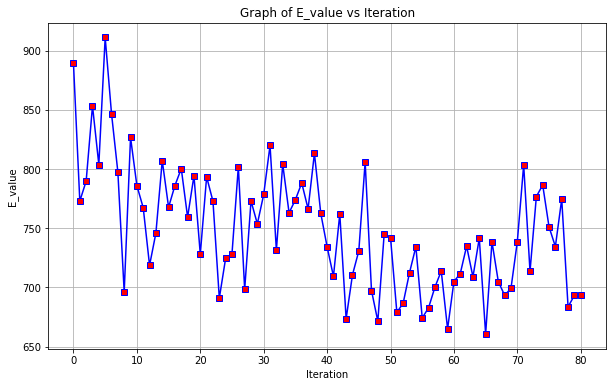

In [ ]:
 import matplotlib.pyplot as plt
 fig,ax = plt.subplots(1, figsize=(10,6))
 x = np.arange(0,len(E))
 y = np.array(E)
 ax.set(xlabel='Iteration', ylabel='E_value',
       title='Graph of E_value vs Iteration')
 plt.grid(True)
 plt.rc('grid', linestyle="dotted", color='black')
 ax.plot(x,y,color='blue',marker='s',markerfacecolor='red',markersize=6)


## Scatter plot with two design parameter 
This code is valid for n=2 i.e. only for two design parameter.

In [ ]:
if(n==2):
  import matplotlib.pyplot as plt
  fig=plt.figure()
  ax=fig.add_axes([0,0,1,1])
  ax.scatter(x1_parameter, x2_parameter, color='b')
  ax.set_xlabel('x1_parameter')
  ax.set_ylabel('x2_parameter')
  ax.set_title('Design space with optimal design points')
  plt.grid(True)
  plt.rc('grid', linestyle="dashdot", color='black')
  plt.show()
else:
  print("Since no. of design parameter is not 'n=2' then it can not be plotted.")

Since no. of design parameter is not 'n=2' then it can not be plotted.


## Scatter plot with three parameter 
This code is valid for n=3 i.e. only for three design parameter.

In [ ]:
if(n==3):
 import matplotlib.pyplot as plt
 from mpl_toolkits.mplot3d import Axes3D
 import numpy as np

 x = x1_parameter
 y = x2_parameter
 z = x3_parameter

 fig = plt.figure(figsize=(10,8))
 ax = fig.add_subplot(111, projection='3d')
 ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
 ax.set_xlabel("x1_value"); ax.set_ylabel("x2_value");
 ax.set_zlabel("X3_value");
 plt.title("Scatter plot of three design parameter");
 plt.show()
else:
  print("Since no. of design parameter is not 'n=3' then it can not be plotted.")

Since no. of design parameter is not 'n=3' then it can not be plotted.


## Output_Value 2

In [ ]:

P_test = np.array(P_out)
#  list_of_alpha = [0.1,0.2,0.5,0.6,0.7]
list_of_alpha = [i*5 for i in range(0,10)]
# list_of_alpha=[0.2]
Emin = [0 for i in range(0,len(list_of_alpha))]
EminArr=Emin
E_converged=[0 for i in range(0,len(list_of_alpha))]
E_lenght=[0 for i in range(0,len(list_of_alpha))]
E_list = [None for i in range(len(list_of_alpha))]
E1_list = [None for i in range(len(list_of_alpha))]
E2_list = [None for i in range(len(list_of_alpha))]
E3_list = [None for i in range(len(list_of_alpha))]
EArr = E_lenght
# print(P_out)
for i in range(0,len(list_of_alpha)):
 P_test = np.array(P_out)
 P_test,T_best,E,e_min,E1,E2,E3 = designer(P_test,iteration,threshold,list_of_alpha[i],BETA, CONSTRAINT)
 EminArr[i]=e_min
 E_converged[i]=E[len(E)-1]
 EArr[i] = len(E)
 E_list[i]=E
 E1_list[i]=E1
 E2_list[i]=E2
 E3_list[i]=E3
 # print("initial P:",P_out)
 # print(getMatrixFromT_best(P_out,T_best))
 print("alpha",list_of_alpha[i],",E_min=",EminArr[i],",E_converged=",E_converged[i],",T best:",T_best,", E_len:",len(E),"E=",E_list[i],"E3=",E3_list[i])
 print(EArr)


alpha 0 ,E_min= 209.01278809527867 ,E_converged= 209.01278809527867 ,T best: [6, 7, 8, 8, 8, 7, 8, 6, 8, 4, 8, 8, 8, 6, 8] , E_len: 86 E= [558.5968330132814, 548.6074479534694, 445.82268729604846, 480.4126859894693, 436.97423402991996, 430.42880430983587, 424.6629358965349, 417.97837963570106, 403.2594586961919, 424.3715679117462, 415.6422717794571, 412.15007814574864, 400.19497309343814, 385.1538499619424, 377.04309392641005, 378.56832298122583, 358.8432363301644, 336.7178546826181, 337.7264081825018, 333.6985552145395, 342.2957917426247, 355.22823356799876, 313.34185197205653, 289.9056139849515, 305.3887079308797, 294.7312360308854, 310.99077557734836, 287.695963626952, 294.3978547639223, 306.1972843739683, 294.23063608412116, 290.697349492613, 279.67072954554, 287.1377970047664, 290.80247312443225, 273.177333759565, 275.2918662684417, 270.12424973954376, 271.23041919132936, 250.38300619527172, 266.50057631350967, 271.42006950987474, 274.728309726497, 275.9905481264484, 267.612164487

## Plot Graph of E_value vs iteration for various Alpha

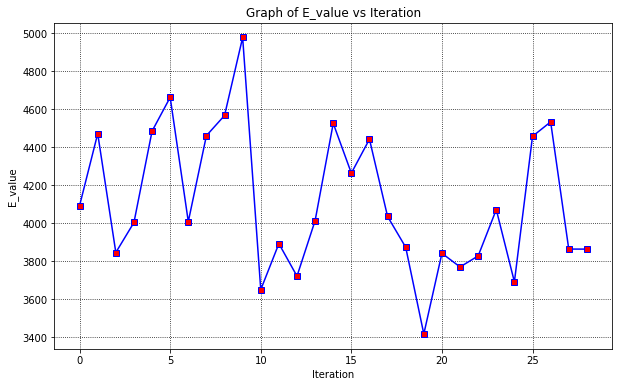

In [ ]:
 import matplotlib.pyplot as plt
 fig,ax = plt.subplots(1, figsize=(10,6))
 x = np.arange(0,len(E))
 y = np.array(E)
 ax.set(xlabel='Iteration', ylabel='E_value',
       title='Graph of E_value vs Iteration')
 plt.grid(True)
 plt.rc('grid', linestyle="dotted", color='black')
 ax.plot(x,y, color='blue',marker='s',markerfacecolor='red',markersize=6)
    

## Plot graph of various alpha_value vs E_converged

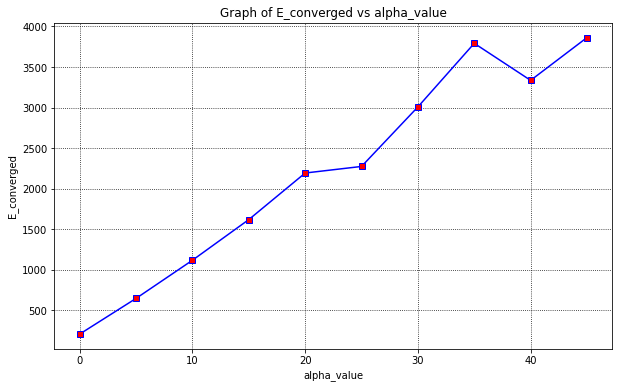

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,figsize=(10,6))
x = np.array(list_of_alpha)
y = np.array(E_converged)
ax.set(xlabel='alpha_value', ylabel='E_converged',
       title='Graph of E_converged vs alpha_value')
plt.grid()
plt.rc('grid', linestyle="dotted", color='black')
ax.plot(x,y,color='blue',marker='s',markerfacecolor='red',markersize=6)

## Plot graph of various alpha_value vs no. of iteration

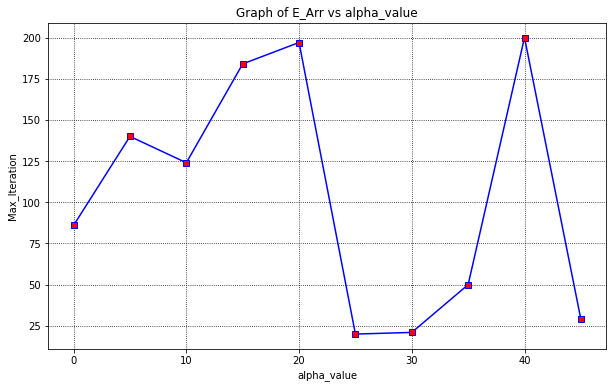

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,figsize=(10,6))
x = np.array(list_of_alpha)
y = np.array(EArr)
ax.set(xlabel='alpha_value', ylabel='Max_Iteration',
       title='Graph of E_Arr vs alpha_value')
plt.grid(True)
plt.rc('grid', linestyle="dotted", color='black')
ax.plot(x,y,color='blue',marker='s',markerfacecolor='red',markersize=6)

## Scatter plot with two design parameter for various Alpha
This code is valid for n=2 i.e. only for two design parameter.

In [ ]:
if(n==2):
  import matplotlib.pyplot as plt
  fig=plt.figure()
  ax=fig.add_axes([0,0,1,1])
  ax.scatter(x1_parameter, x2_parameter, color='b')
  ax.set_xlabel('x1_parameter')
  ax.set_ylabel('x2_parameter')
  ax.set_title('Design space with optimal design points')
  plt.grid()
  plt.rc('grid', linestyle="-", color='grey')
  plt.show()
else:
  print("Since no. of design parameter is not 'n=2' then it can not be plotted.")

Since no. of design parameter is not 'n=2' then it can not be plotted.


## Scatter plot with three parameter for various Alpha
This code is valid for n=3 i.e. only for three design parameter.

In [ ]:
if(n==3):
 import matplotlib.pyplot as plt
 from mpl_toolkits.mplot3d import Axes3D
 import numpy as np

 x = x1_parameter
 y = x2_parameter
 z = x3_parameter

 fig = plt.figure(figsize=(10,8))
 ax = fig.add_subplot(111, projection='3d')
 ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
 ax.set_xlabel("x1_value"); ax.set_ylabel("x2_value");
 ax.set_zlabel("X3_value");
 plt.title("Scatter plot of three design parameter");
 plt.show()
else:
  print("Since no. of design parameter is not 'n=3' then it can not be plotted.")

Since no. of design parameter is not 'n=3' then it can not be plotted.


### Print End time

In [ ]:
# import datetime
import datetime 
import pytz  
# current date and time
End_time = datetime.datetime.now(pytz.timezone('Asia/Kolkata'))
print(" DateTime:", End_time)

 DateTime: 2020-06-23 19:09:37.231900+05:30


### Time Duration to run the code 

In [ ]:
# import datetime
from datetime import datetime
# Difference between two datetime
Time_duration = End_time-Start_time
print("Time_duration: ",Time_duration)

Time_duration:  2:31:49.304987


## Plot multiple graph 

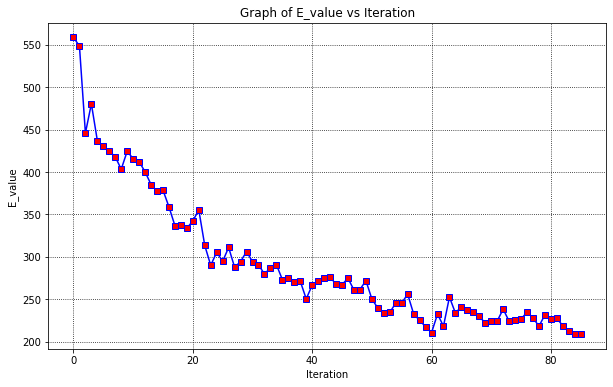

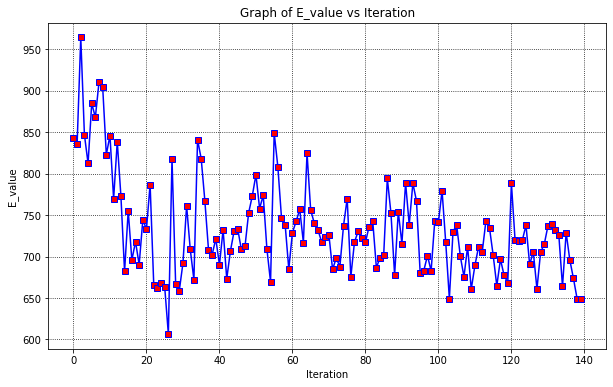

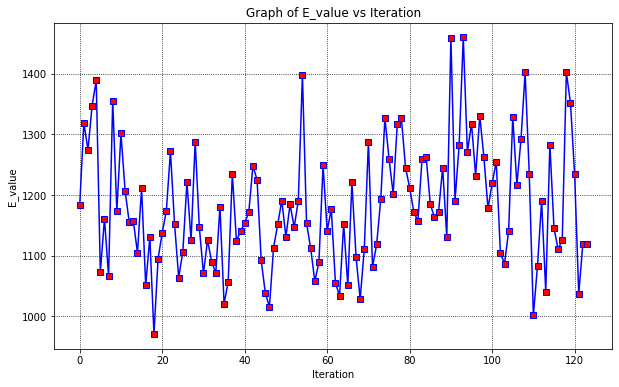

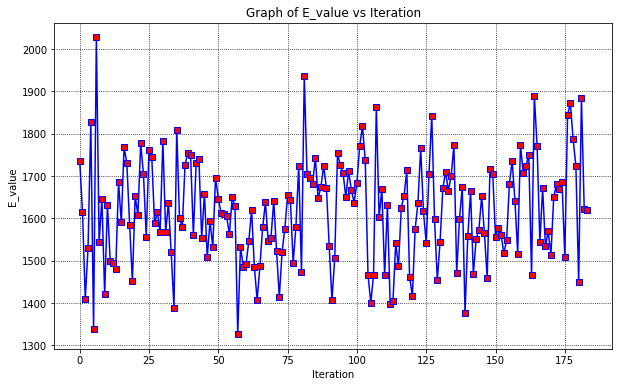

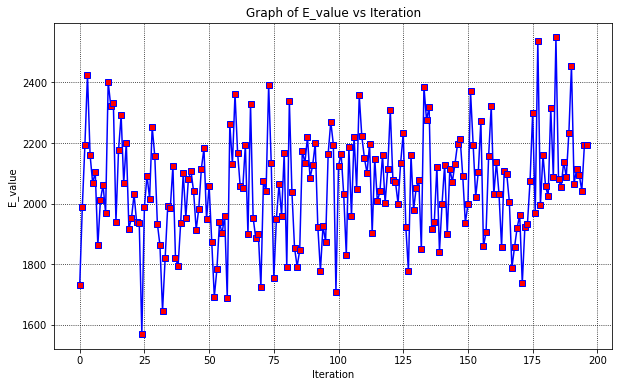

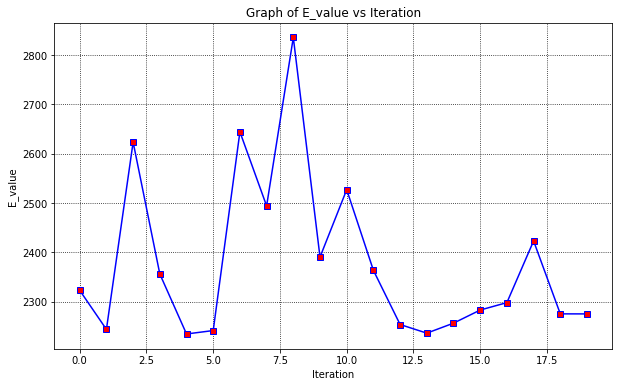

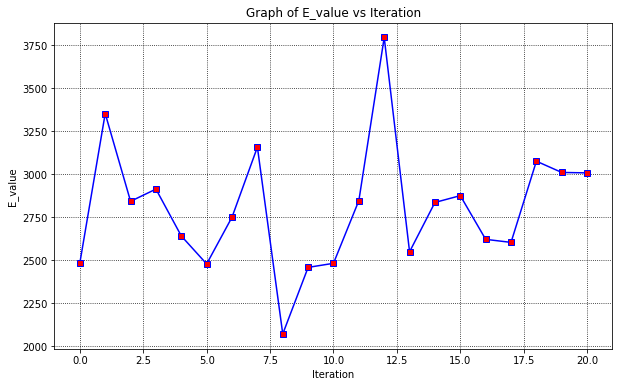

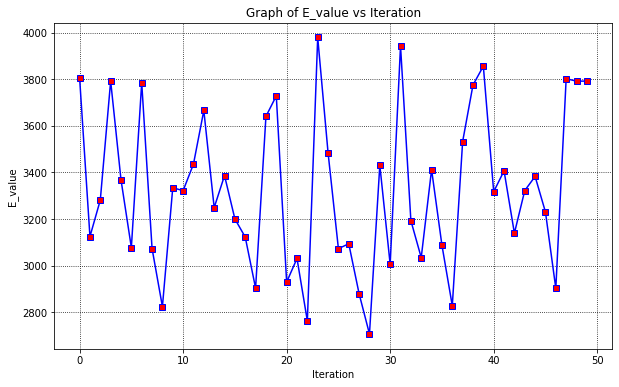

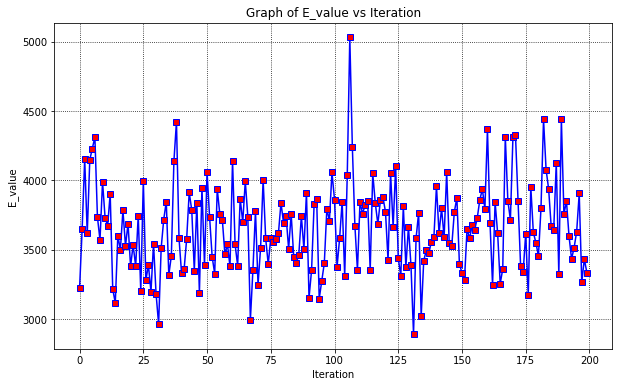

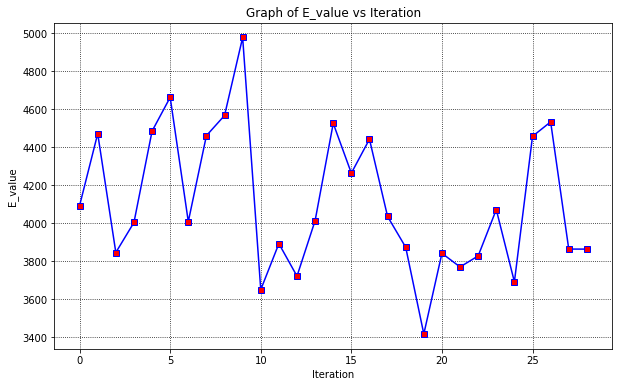

In [ ]:
for E in E_list:
  fig,ax = plt.subplots(1, figsize=(10,6))
  x = np.arange(0,len(E))
  y = np.array(E)
  ax.set(xlabel='Iteration', ylabel='E_value',
        title='Graph of E_value vs Iteration')
  plt.grid(True)
  plt.rc('grid', linestyle="dotted", color='black')
  ax.plot(x,y,color='blue',marker='s',markerfacecolor='red',markersize=6)



# fig = plt.figure()
# gs = fig.add_gridspec(len(list_of_alpha), len(E_list[0]))
# axs = gs.subplots(sharex=True, sharey=True)
# fig.suptitle('Sharing both axes')
# for i in range(0,len(list_of_alpha)):
#   x = [i for i in range(1, len(list_of_alpha)+1)]
#   y = E_list[i]
#   axs[i].plot(x,y)

# # Hide x labels and tick labels for all but bottom plot.
# for ax in axs:
#     ax.label_outer()

### graph plot multiple in same graph

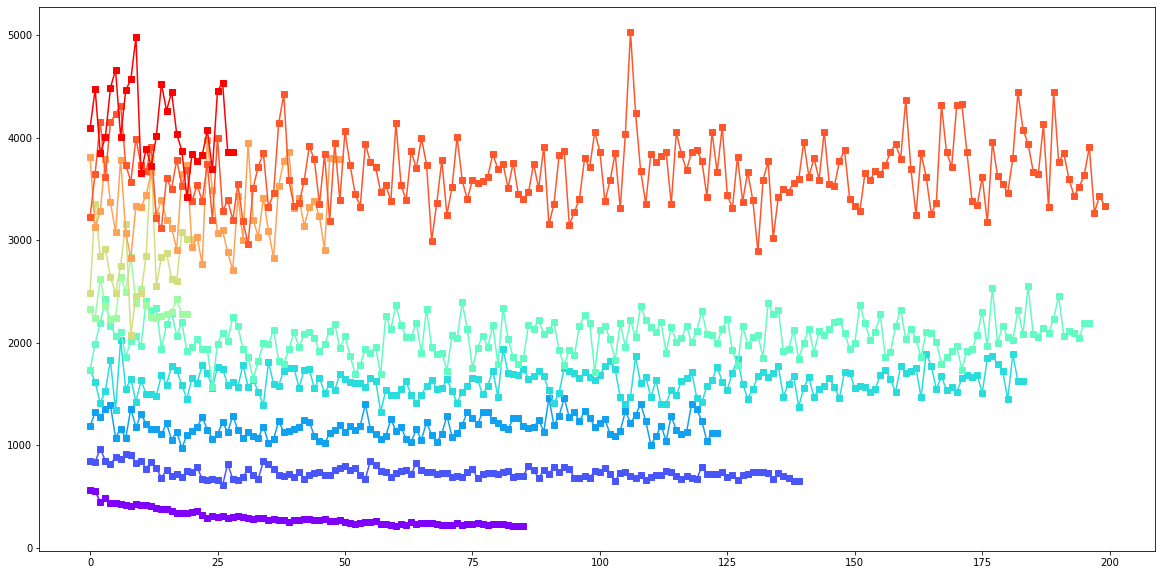

In [ ]:
"""
fig,ax = plt.subplots(1, figsize=(10,6))
ax.set(xlabel='Iteration', ylabel='E_value',
        title='Graph of E_value vs Iteration')
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) +
                           cycler('linestyle', ['-', '--', ':', '-.'])))
for E in E_list:
  x = np.arange(0,len(E))
  y = np.array(E)
  plt.grid(True)
  # plt.rc('grid', linestyle="dotted", color='black')
  ax.plot(x,y,color='blue',marker='o',markerfacecolor='red',markersize=6)
"""

# from cycler import cycler
# import numpy as np
# import matplotlib.pyplot as plt


# x = np.arange(0,len(E))
# # offsets = np.linspace(0, 2*np.pi, 4, endpoint=False)
# # Create array with shifted-sine curve along each column
# yy = np.array(E)

# # 1. Setting prop cycle on default rc parameter
# plt.rc('lines', linewidth=4)
# plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) +
#                            cycler('linestyle', ['-', '--', ':', '-.'])))
# fig, ax = plt.subplots(nrows=len(list_of_alpha),figsize=(10,6*len(list_of_alpha)))
# print(ax)
# for i in range(0, len(list_of_alpha)):
#   ax[i].plot(E_list[i])
#   title = "alpha="+str(list_of_alpha[i])
#   ax[i].set_title(title)
#   ax[i].set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']) +
#                    cycler('lw', [1, 2, 3, 4]))


# # fig, (ax0, ax1) = plt.subplots(nrows=2)
# # ax0.plot(yy)
# # ax0.set_title('Set default color cycle to rgby')

# # # 2. Define prop cycle for single set of axes
# # ax1.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']) +
# #                    cycler('lw', [1, 2, 3, 4]))
# # ax1.plot(yy)
# # ax1.set_title('Set axes color cycle to cmyk')

# # Tweak spacing between subplots to prevent labels from overlapping
# fig.subplots_adjust(hspace=0.3)
# plt.show()


from matplotlib.pyplot import cm
import numpy as np

#variable n below should be number of curves to plot

x = np.arange(0,len(E))
#version 1:
# color=cm.rainbow(np.linspace(0,1,len(list_of_alpha)))
# for i,c in zip(range(len(list_of_alpha)),color):
#    x = np.arange(0,len(E_list[i]))
#    y = E_list[i]
#    plt.plot(x, y,c=c)

#or version 2:
plt.figure(figsize=(20,10))
color=iter(cm.rainbow(np.linspace(0,1,len(list_of_alpha))))
for i in range(len(list_of_alpha)):
   c=next(color)
   x = np.arange(0,len(E_list[i]))
   y = E_list[i]
   plt.plot(x, y,color=c,marker='s',markerfacecolor=c,markersize=6)
plt.show()

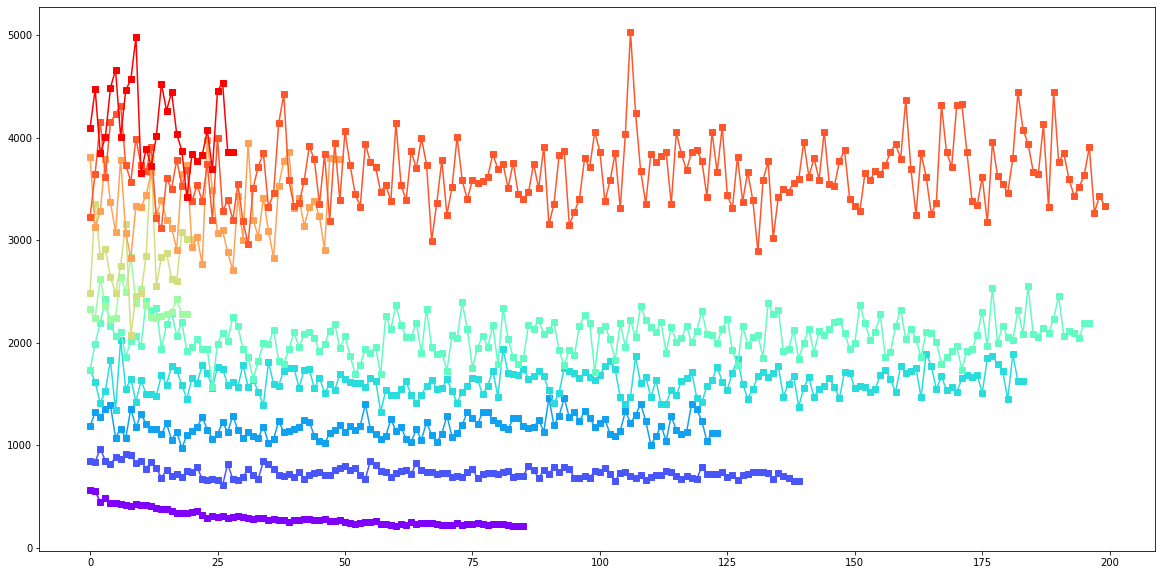

In [ ]:
# Multiple plot for various alpha
plt.figure(figsize=(20,10))
color=iter(cm.rainbow(np.linspace(0,1,len(list_of_alpha))))
for i in range(len(E_list)):
   c=next(color)
   x = np.arange(0,len(E_list[i]))
   y = E_list[i]
   plt.plot(x, y,color=c,marker='s',markerfacecolor=c,markersize=6)
plt.show()

## Output 3

In [ ]:

P_test = np.array(P_out)
beta = np.random.randint(low=1,high=15, size=(5, 5))  # Three-dimensional array
print("beta = \n",beta)
print(beta[0])
Emin = [0 for i in range(0,beta.shape[0])]
print(Emin)
EminArr=Emin
E_converged=[0 for i in range(0,beta.shape[0])]
E_lenght=[0 for i in range(0,beta.shape[0])]
E_list = [None for i in range(beta.shape[0])]
E1_list = [None for i in range(beta.shape[0])]
E2_list = [None for i in range(beta.shape[0])]
E3_list = [None for i in range(beta.shape[0])]
EArr = E_lenght
# print(P_out)
for i in range(0,beta.shape[0]):
 P_test = np.array(P_out)
 P_test,T_best,E,e_min,E1,E2,E3 = designer(P_test,iteration,threshold,ALPHA,beta[i], CONSTRAINT)
 EminArr[i]=e_min
 E_converged[i]=E[len(E)-1]
 EArr[i] = len(E)
 E_list[i]=E
 E1_list[i]=E1
 E2_list[i]=E2
 E3_list[i]=E3
 # print("initial P:",P_out)
 # print(getMatrixFromT_best(P_out,T_best))
 print("beta",beta[i],",E_min=",EminArr[i],",E_converged=",E_converged[i],",T best:",T_best,", E_len:",len(E),"E=",E_list[i])
 print(EArr)

beta = 
 [[ 4  8 13 12  8]
 [ 3 10  8  1  8]
 [13 13 10  7  6]
 [ 4 14  5  6 14]
 [12  7 11 12  4]]
[ 4  8 13 12  8]
[0, 0, 0, 0, 0]
beta [ 4  8 13 12  8] ,E_min= 507.54334125854643 ,E_converged= 793.6322582321785 ,T best: [1, 5, 8, 4, 8, 8, 7, 4, 3, 1, 8, 3, 3, 5, 6] , E_len: 61 E= [924.7205335898811, 946.1682971893872, 829.2413014119794, 899.9108421383255, 857.9410598089004, 875.6740096484622, 929.5711534702868, 918.7452603231994, 890.5796002635628, 840.1107347285737, 773.7622829366296, 813.0077170584693, 788.9431218369033, 757.8044773568354, 838.7278877547724, 807.9360279555084, 835.2760171754217, 779.9815985560584, 851.7949321675168, 903.9465283207946, 801.695633744348, 776.6568288902505, 827.8780026451758, 790.046807287054, 839.2805004923787, 822.3361764712424, 833.156220010082, 814.9140409260947, 848.591182473194, 760.3739423648021, 728.3756184947221, 828.873195868641, 814.8246479719518, 812.9614376450835, 760.348393366299, 734.3020817154463, 741.2817325217138, 752.0453892357862,

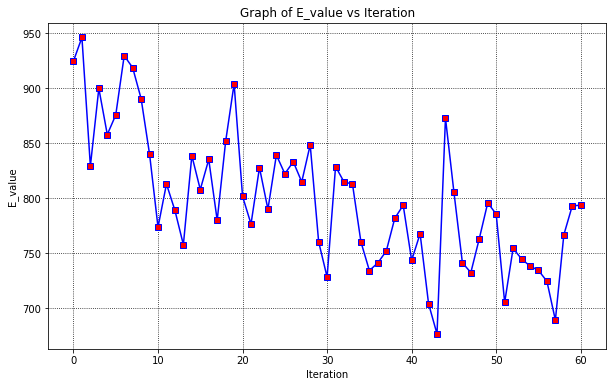

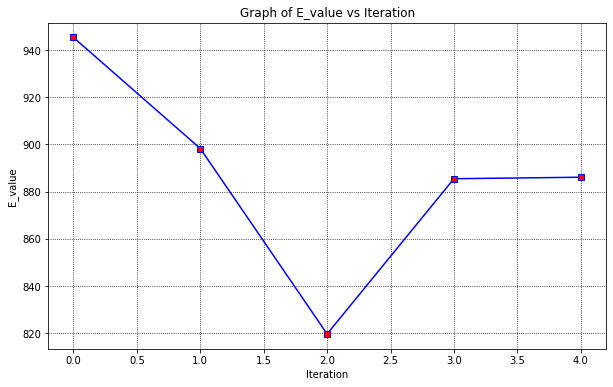

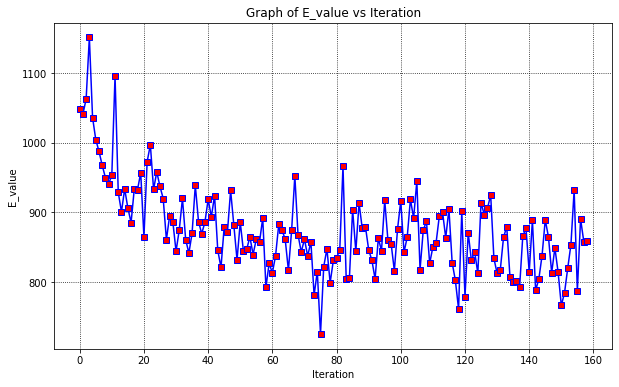

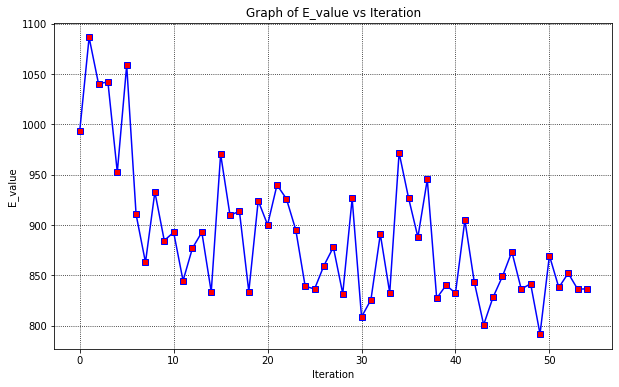

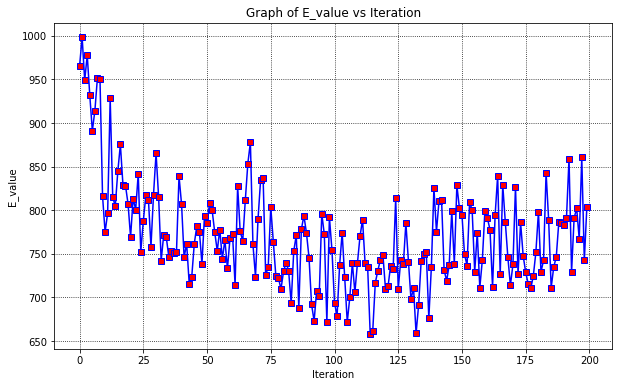

In [ ]:
for E in E_list:
  fig,ax = plt.subplots(1, figsize=(10,6))
  x = np.arange(0,len(E))
  y = np.array(E)
  ax.set(xlabel='Iteration', ylabel='E_value',
        title='Graph of E_value vs Iteration')
  plt.grid(True)
  plt.rc('grid', linestyle="dotted", color='black')
  ax.plot(x,y,color='blue',marker='s',markerfacecolor='red',markersize=6)

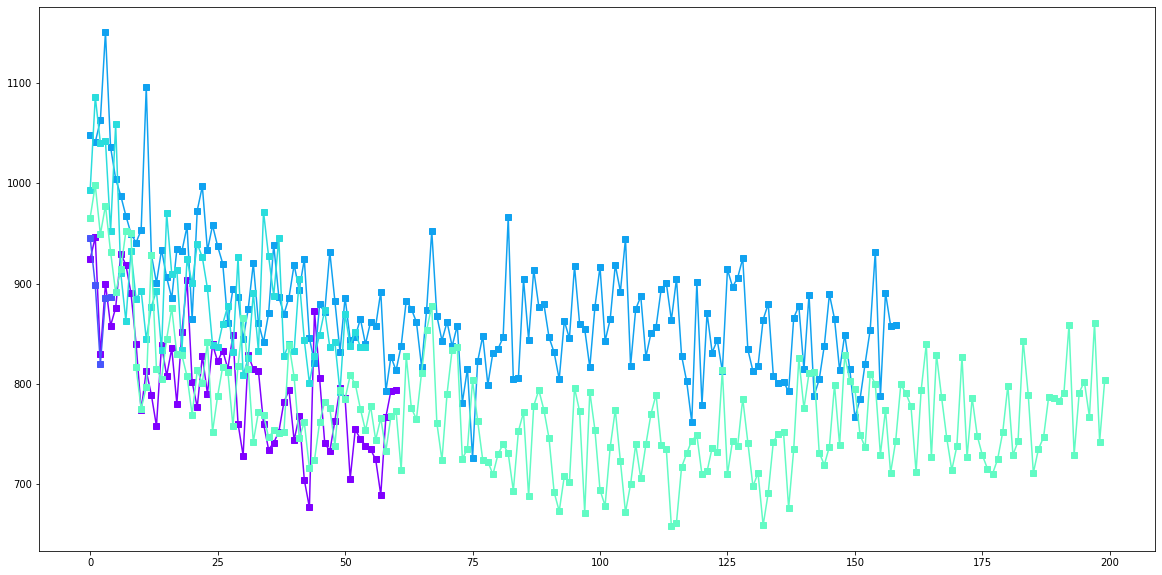

In [ ]:
plt.figure(figsize=(20,10))
color=iter(cm.rainbow(np.linspace(0,1,len(list_of_alpha))))
for i in range(len(E_list)):
   c=next(color)
   x = np.arange(0,len(E_list[i]))
   y = E_list[i]
   plt.plot(x, y,color=c,marker='s',markerfacecolor=c,markersize=6)
plt.show()